In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import gc

def cout(var):
  # Get the unique labels and their counts in train_labels
  unique_labels, counts = np.unique(var, return_counts=True)

  # Display the number of classes
  num_classes = len(unique_labels)
  print("Number of classes:", num_classes)

  # Display the count of each class
  for label, count in zip(unique_labels, counts):
      print("Class {} has {} samples".format(label, count))

In [ ]:

#------------------------------------------------------------------------------
#                          load data
#------------------------------------------------------------------------------

x=np.load('/content/drive/MyDrive/server_2/fast_data/x.npy')
old_y=np.load('/content/drive/MyDrive/server_2/fast_data/y.npy')

cout(old_y[:len(x)//2])

from keras.utils import to_categorical
y = to_categorical(old_y, num_classes=4)

# Assuming train_images and train_labels are already defined
#X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(x[:len(x)//2],y[:len(x)//2], test_size=0.2, random_state=42)


del old_y
del x
del y
gc.collect()

# Print the shapes of the new sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)



Number of classes: 4
Class 0 has 506 samples
Class 1 has 493 samples
Class 2 has 516 samples
Class 3 has 485 samples
X_train shape: (1600, 224, 224, 3)
y_train shape: (1600, 4)
X_val shape: (400, 224, 224, 3)
y_val shape: (400, 4)


In [ ]:
import tensorflow as tf
from keras import regularizers
from keras.regularizers import l2
from keras.models import Sequential, Model
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Ftrl, Nadam, RMSprop, SGD
from keras.layers import LSTM, Dense, Dropout, Reshape, Flatten, Activation, BatchNormalization,Conv2D, MaxPooling2D, Input ,GlobalAveragePooling2D

#------------------------------------------------------------------------------
#                          checkpoint and earlystopping
#------------------------------------------------------------------------------


# checkpoint
filepath="cnn-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystopping = EarlyStopping(monitor='val_accuracy',
                              patience=9,
                              restore_best_weights=True)



print("earlystopping and checkpoint attched on model...")


In [ ]:



def create_cnn_model(input_shape=(224,224,3), num_classes=4, reg_strength=0.01, act='relu'):
    model = Sequential()
    # feature extraction
    model.add(Conv2D(32, (3,3), input_shape=input_shape, kernel_regularizer=l2(reg_strength)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    num_filters = [64, 128, 256, 512, 1024]
    for filters in num_filters:
        model.add(Conv2D(filters, (3,3), kernel_regularizer=l2(reg_strength)))
        model.add(BatchNormalization())
        model.add(Activation(act))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # classifier
    model.add(Dense(1024, kernel_regularizer=l2(reg_strength)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    model.add(Dense(512, kernel_regularizer=l2(reg_strength)))
    model.add(BatchNormalization())
    model.add(Activation(act))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    print("cnn model running")
    print(f"Total trainable parameters: {model.count_params()}")
    model.summary()
    return model

def cnn_lstm():
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Conv2D(256, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Conv2D(512, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))
    cnn_model.add(Conv2D(1024, (3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2)))
    # Reshape the output of the CNN model to match the expected input shape of the LSTM model
    cnn_output_shape = cnn_model.output_shape[1] * cnn_model.output_shape[2] * cnn_model.output_shape[3]
    reshape_layer = Reshape((1024, -1))
    cnn_model.add(reshape_layer)

    # Define the LSTM model to learn temporal dependencies between the images
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(32))
    lstm_model.add(Dense(4, activation='softmax'))

    # Combine the CNN and LSTM models
    model = Sequential()
    model.add(cnn_model)
    model.add(lstm_model)
    model.summary()
    return model


def build_densenet121(input_shape=(224, 224, 3)):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Add global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add fully connected layer with 256 neurons and ReLU activation
    x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    predictions = Dense(4, activation='softmax')(x)
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def load_vgg16_model():
    print("vgg16 model created...")
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model



In [ ]:
model=build_densenet121()
model

29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:

from keras.layers import Concatenate, Input
import tensorflow as tf

def concat(inputs, x):
    #resize inputs at a dimension of x
    # Resize and convolve the input tensor
    resized_inputs = tf.image.resize(inputs, size=(x.shape[1], x.shape[2]))
    resized_inputs = Conv2D(filters=16, kernel_size=3, padding='same')(resized_inputs)
    # Concatenate the output of the DenseLayer to the input
    return Concatenate()([x, resized_inputs])


def create_cnn_model(input_shape=(224,224,3), num_classes=4, reg_strength=0.01, act='relu', filters=32):
    print("cnn with concatination power")
    model = Sequential()
    # feature extraction
    input_layer = Input(shape=input_shape)
    x = Conv2D(filters, (3,3), input_shape=input_shape, kernel_regularizer=l2(reg_strength))(input_layer)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    inputs = x

    num_filters = [64, 128, 256, 512, 1024]
    for f in num_filters:
        x = Conv2D(f, (3,3), kernel_regularizer=l2(reg_strength))(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        inputs = concat(inputs, x)

    # classification
    x = Flatten()(inputs)
    x = Dense(128, activation=act)(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[input_layer], outputs=[output_layer])

    return model

model=create_cnn_model()

In [ ]:

from keras.layers import Concatenate, Input
import tensorflow as tf

def concat(inputs, x):
    #resize inputs at a dimension of x
    # Resize and convolve the input tensor
    resized_inputs = tf.image.resize(inputs, size=(x.shape[1], x.shape[2]))
    resized_inputs = Conv2D(filters=16, kernel_size=3, padding='same')(resized_inputs)
    # Concatenate the output of the DenseLayer to the input
    return Concatenate()([x, resized_inputs])


def create_cnn_model(input_shape=(224,224,3), num_classes=4, reg_strength=0.01, act='relu', filters=32):
    print("cnn with concatination power")
    model = Sequential()
    # feature extraction
    # layer 1
    input_layer = Input(shape=input_shape)
    x = Conv2D(16, (3,3), input_shape=input_shape, kernel_regularizer=l2(reg_strength))(input_layer)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    inputs = x

    # layer 2
    x = Conv2D(32, (3,3) ,kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    inputs = concat(inputs, x)

    # layer 3
    x = Conv2D(48, (3,3),strides=1, padding='same' , kernel_regularizer=l2(reg_strength))(x)
    x = Conv2D(48, (3,3), padding='same' , kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    inputs = concat(inputs, x)

    # layer 4
    x = Conv2D(64, (3,3), strides=1, padding='same',kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    inputs = concat(inputs, x)

    # layer 5
    x = Conv2D(128, (3,3), kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    inputs = concat(inputs, x)

    # layer 6
    x = Conv2D(256, (3,3), kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    inputs = concat(inputs, x)

    # layer 7
    x = Conv2D(512, (3,3), kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation(act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    inputs = concat(inputs, x)

    # classification
    x = Flatten()(inputs)
    x = Dense(128, activation=act)(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[input_layer], outputs=[output_layer])
    return model


In [ ]:
#------------------------------------------------------------------------------
#                          define model
#------------------------------------------------------------------------------









#------------------------------------------------------------------------------
#                          model selection
#------------------------------------------------------------------------------

#model=load_vgg16_model()
#model=cnn_lstm()
#model=build_densenet121()
#model.summary()
model=create_cnn_model()  #84


opt = Adam(
    learning_rate=0.00001,
    #beta_1=0.03,
    #beta_2=0.5
)

callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                factor=.7,
                                                patience=5,
                                                verbose=1)

model.compile(loss='categorical_crossentropy',
          optimizer=opt,
          metrics=['accuracy'])

gc.collect()



#------------------------------------------------------------------------------
#                          training start
#------------------------------------------------------------------------------

# Train all layers
history=model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          validation_data=(X_val,y_val),
          callbacks=[callback,earlystopping,checkpoint])

#callbacks=[callback,earlystopping,checkpoint]


cnn with concatination power
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 9.1343 - accuracy: 0.3700
Epoch 1: val_accuracy did not improve from 0.82250
50/50 [==============================] - 9s 130ms/step - loss: 9.1343 - accuracy: 0.3700 - val_loss: 9.0437 - val_accuracy: 0.2275 - lr: 1.0000e-05
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 8.7927 - accuracy: 0.5094
Epoch 2: val_accuracy did not improve from 0.82250
50/50 [==============================] - 6s 117ms/step - loss: 8.7927 - accuracy: 0.5094 - val_loss: 9.0790 - val_accuracy: 0.2275 - lr: 1.0000e-05
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 8.7311 - accuracy: 0.5375
Epoch 3: val_accuracy did not improve from 0.82250
50/50 [==============================] - 6s 119ms/step - loss: 8.7311 - accuracy: 0.5375 - val_loss: 9.1182 - val_accuracy: 0.2300 - lr: 1.0000e-05
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 8.5874 - accuracy: 0.591

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dropout, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def DenseNet9():
    # Input layer
    inputs = Input(shape=(224,224,3))

    # First convolutional layer
    x = Conv2D(filters=16, kernel_size=3, padding='same')(inputs)

    # 4 DenseBlocks with 2 DenseLayers each
    for i in range(4):
        # DenseBlock
        for j in range(2):
            # Batch normalization layer
            x = BatchNormalization()(x)
            # ReLU activation layer
            x = ReLU()(x)
            # Convolutional layer
            x = Conv2D(filters=16, kernel_size=3, padding='same')(x)
            # Dropout layer
            x = Dropout(0.2)(x)

                # Resize and convolve the input tensor
            resized_inputs = tf.image.resize(inputs, size=(x.shape[1], x.shape[2]))
            resized_inputs = Conv2D(filters=16, kernel_size=3, padding='same')(resized_inputs)

            # Concatenate the output of the DenseLayer to the input
            x = Concatenate()([x, resized_inputs])

        # Transition layer
        x = BatchNormalization()(inputs)
        x = Conv2D(filters=16, kernel_size=1, padding='same')(x)
        x = Dropout(0.2)(x)
        x = tf.keras.layers.AveragePooling2D()(x)

    # Global average pooling layer
    x = GlobalAveragePooling2D()(x)
    # Output layer
    outputs = Dense(4, activation='softmax')(x)
    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

model=DenseNet9()


In [ ]:

# del model
# #del predicted_labels
# # del report
# # del cm
# #del plt
gc.collect()


154

In [ ]:
# ---------------------------------------------------------------------------------------------------
#                                      result
# --------------------------------------------------------------------------------------------------

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# generate predicted labels for the test data
predicted_labels = model.predict(X_val)
predicted_labels = np.round(predicted_labels)

# generate the classification report
report = classification_report(y_val, predicted_labels)

# print the report to the console
print(report)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=1),np.argmax(predicted_labels, axis=1))

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# adam lr-0.0001 on contrast

13/13 [==============================] - 1s 49ms/step
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       100
           1       0.86      0.73      0.79        95
           2       0.85      0.91      0.88       114
           3       0.76      0.75      0.76        91

   micro avg       0.83      0.81      0.82       400
   macro avg       0.82      0.80      0.81       400
weighted avg       0.83      0.81      0.81       400
 samples avg       0.81      0.81      0.81       400

Confusion matrix:
[[ 84   6   3   7]
 [  6  69   8  12]
 [  6   2 104   2]
 [ 12   3   8  68]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# ---------------------------------------------------------------------------------------------------
#                                      result
# --------------------------------------------------------------------------------------------------

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# generate predicted labels for the test data
predicted_labels = model.predict(X_val)
predicted_labels = np.round(predicted_labels)

# generate the classification report
report = classification_report(y_val, predicted_labels)

# print the report to the console
print(report)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=1),np.argmax(predicted_labels, axis=1))

# Print the confusion matrix
print('Confusion matrix:')
print(cm)

# adam lr-0.0001 on contrast

13/13 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       100
           1       0.86      0.73      0.79        95
           2       0.85      0.91      0.88       114
           3       0.76      0.75      0.76        91

   micro avg       0.83      0.81      0.82       400
   macro avg       0.82      0.80      0.81       400
weighted avg       0.83      0.81      0.81       400
 samples avg       0.81      0.81      0.81       400

Confusion matrix:
[[ 84   6   3   7]
 [  6  69   8  12]
 [  6   2 104   2]
 [ 12   3   8  68]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


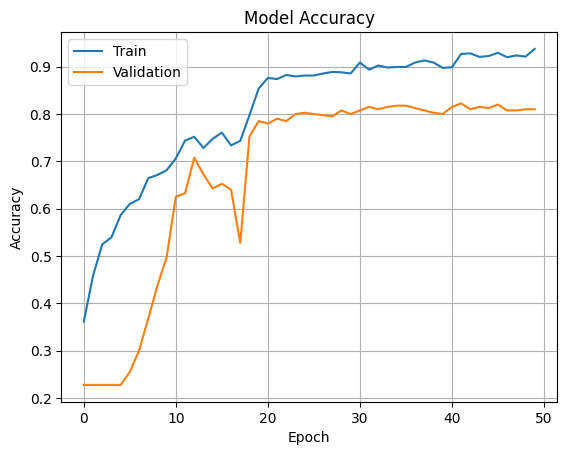

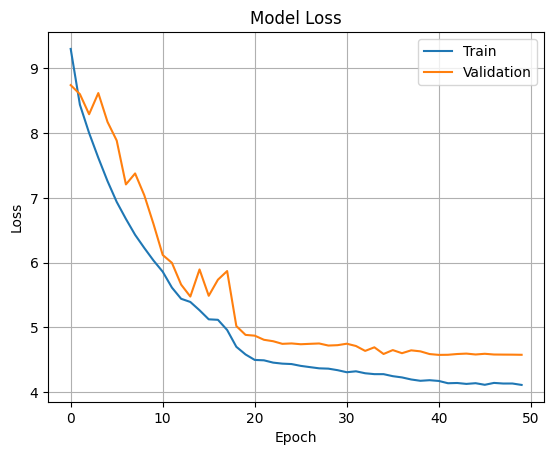

In [ ]:
import matplotlib.pyplot as plt

#densenet
#------------------------------------------------------------------------------
#                          graph
#------------------------------------------------------------------------------

# Plot the training and validation accuracy over each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot the training and validation loss over each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()



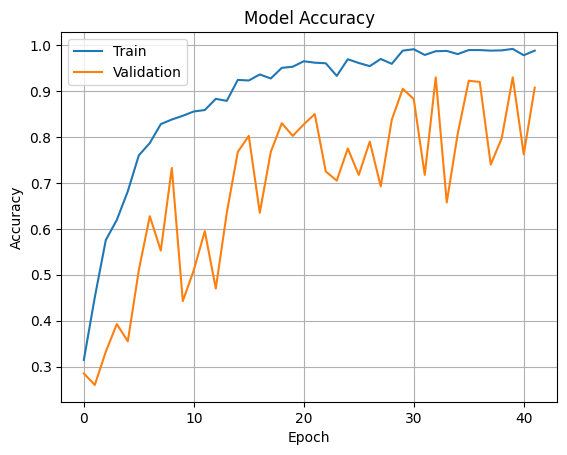

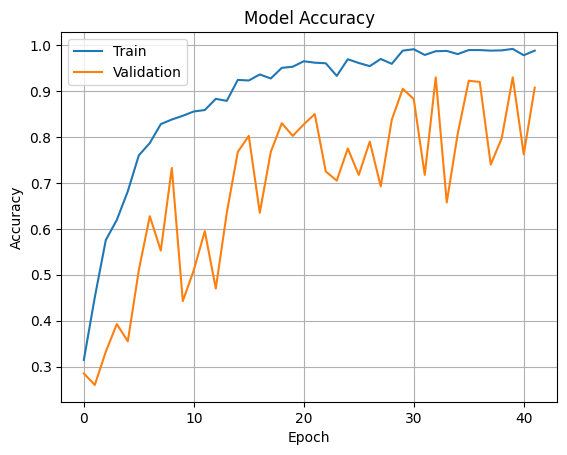

13/13 [==============================] - 4s 97ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       100
           1       0.82      0.95      0.88        95
           2       0.99      0.90      0.94       114
           3       0.94      0.89      0.92        91

   micro avg       0.93      0.92      0.92       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.94      0.92      0.93       400
 samples avg       0.92      0.92      0.92       400

Confusion matrix:
[[ 94   6   0   0]
 [  0  90   1   4]
 [  2   8 103   1]
 [  4   6   0  81]]

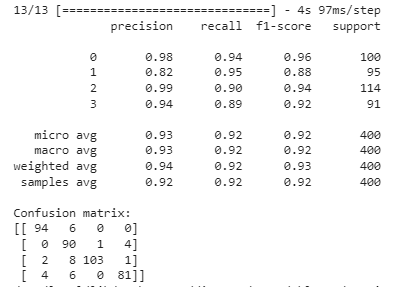

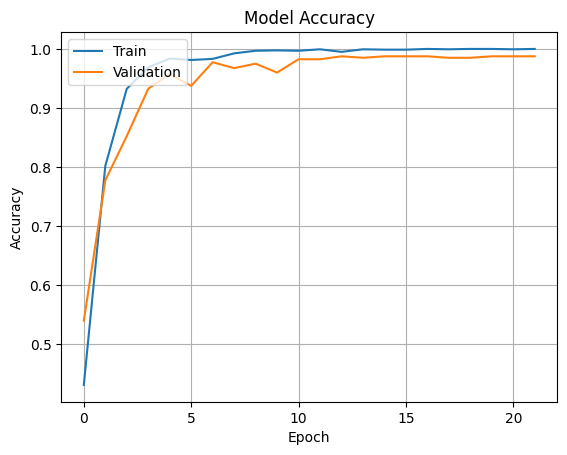

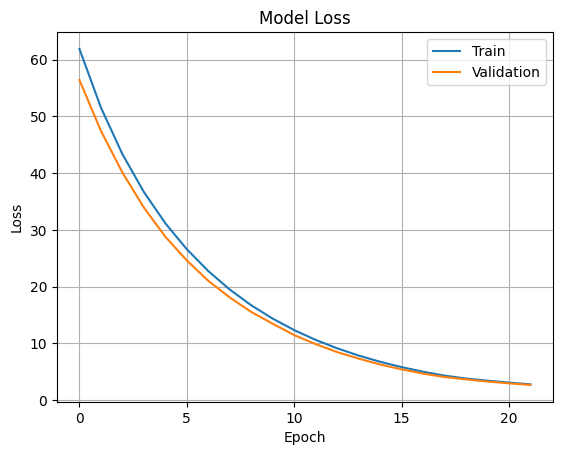

In [ ]:
import matplotlib.pyplot as plt

#densenet
#------------------------------------------------------------------------------
#                          graph
#------------------------------------------------------------------------------

# Plot the training and validation accuracy over each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.show()

# Plot the training and validation loss over each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

